# Embeddings
----

<br>

## **1:** Embedding Models

In this section, we'll review the ideas surrounding natural language processing with deep learning to define what embedding models are and how they're related to the tools we've taken for granted thus far.

<br>

### **Understanding Latent Embeddings**

Latent embeddings represent the middle ground in deep learning networks, bridging the gap between input and output. For instance, let's consider a lightweight two-layer network designed to classify [**MNIST digits**](https://en.wikipedia.org/wiki/MNIST_database). For this, the inputs and outputs might be flattened images and one-hot probability vectors, respectively. Then, the values produced by the first layer in this setup are the latent embeddings of the image which, by optimization, converge into useful representations for the final layer to use. This makes them **semantically rich embeddings** that may not be human-interpretable but can still be leveraged for their raw vector properties.

<br>

### **Word Embeddings: The Building Blocks of Language Models**

Word embeddings are high-dimensional vector representations of individual words, forming the backbone of deep language models. These embeddings are created through an optimization process within an end-to-end pipeline tailored for specific tasks. [**Word2vec**](https://en.wikipedia.org/wiki/Word2vec) is a prominent standalone example for those interested. In practical terms, a token from a language model's $v$-token vocabulary gets mapped from a token index to an $d$-dimensional token embedding:

$$\text{Token Index} \in \{0, 1, \cdots, v-1\} \to \text{Token Embedding} \in \mathbb{R}^{d}$$

For a sequence of $n$ tokens, this mapping extends to the entire sequence:

$$\text{Token Sequence} \in \{0, 1, \cdots, v-1\}^{v} \to \text{Embedding Sequence} \in \mathbb{R}^{n\times d}$$

<br>

### **Sentence/Document Embeddings: Capturing Context and Meaning**

When dealing with sentences or entire documents, embeddings play a crucial role in capturing context, meanings, and interactions between elements. Practically all large language models leverage a **transformer-like architecture** to generate these sentence/document embeddings. The transformer allows the network to communicate both per-token-level and sequence-level information as it becomes useful for the optimization problem.

<br>

### **Decoder Models in Language Generation**

Decoder models, commonly used in chatbots and other language generation tasks, start by taking a sequence of tokens as input. They embed these tokens into a latent sequence, applying unidirectional reasoning to focus on a specific part of the output sequence. From this focused, semantically dense point, the model predicts the next token in the sequence:

$$$$
$$\text{[ Next-Token Generation ]}$$
$$\text{Embedding Sequence} \in \mathbb{R}^{n\times d} \to \text{Latent Sequence} \in \mathbb{R}^{n\times d}$$
$$(\text{Latent Sequence})[\text{last entry}] \in \mathbb{R}^{d} \to \text{Token Prediction} \in \mathbb{R}^{v}$$
$$$$

This process continues, collapsing the token prediction from a vector to a realized token and building up a predicted sequence until a termination condition — such as a length limit or stop token — gets satisfied.

$$$$
$$\text{[ Autoregressive Generation ]}$$
$$(\text{Original + Predicted Embedding Sequence}) \in \mathbb{R}^{(n+1)\times e} \to \text{Token Prediction} \in \mathbb{R}^{v}$$
$$\vdots$$
$$(\text{Original + Predicted Embedding Sequence}) \in \mathbb{R}^{(n+m)\times e} \to \text{Token Prediction} \in \mathbb{R}^{v}$$
$$$$
<br>

### **Encoder Models For Sequence Encoding**

Encoder models use a bidirectional architecture, making them suitable for different types of tasks compared to decoder models. They are particularly effective in tasks like token or sequence prediction. Letting $c$ be a number of classes or regressional values:

$$$$
$$\text{[ Per-Token Prediction ]}$$
$$\text{Embedding Sequence} \in \mathbb{R}^{n\times d} \to \text{Latent Sequence} \in \mathbb{R}^{n\times d} \to \text{Per-Token Predictions} \in \mathbb{R}^{n\times c}$$

$$$$
$$\text{[ Full-Sequence Prediction ]}$$
$$\text{Embedding Sequence} \in \mathbb{R}^{n\times d} \to \text{Latent Sequence} \in \mathbb{R}^{n\times d}$$
$$(\text{Latent Sequence})[\text{0th entry}] \in \mathbb{R}^{d} \to \text{Sequence Prediction} \in \mathbb{R}^{c}$$

<br>

> <img src="https://dli-lms.s3.amazonaws.com/assets/s-fx-15-v1/imgs/encoder-decoder.png" width=1200px/>
<!-- > <img src="https://drive.google.com/uc?export=view&id=1lhswkAgb5TlDxezg3qDNZQKbOMGFz7H5" width=1200px/> -->


----

## **2:** Using An NVIDIAEmbeddings Model

For this experiment, we will use an embedding model with two pathways: shorter-form "query" and longer-form "passage" pathways. In doing so, we will see how to properly reason about its outputs and utilize it to complement our existing LLM toolset!

To pull in our model, we will once again take advantage of the AI foundation model endpoints and its integration with LangChain! This part of the notebook will closely resemble the [**official NVIDIAEmbeddings documentation**](https://python.langchain.com/docs/integrations/text_embedding/nvidia_ai_endpoints).


At the time of writing, the current recommended model for this task is the [**NVIDIA Retrieval QA Embedding model**](https://build.nvidia.com/nvidia/embed-qa-4), which is a legally-vetted fine-tuned variant of the [**E5-Large embedding model**](https://huggingface.co/intfloat/e5-large) listed under the `nvolveqa_40k` designation. This designation may have changed, so check over the available list and identify the current recommendation.

<br>

### **Identifying Our Model**

Among your available models, you should find an embedding model suitable for discriminating between human-readable passages. After identifying the endpoint of interest, create an `NVIDIAEmbeddings` instance that will connect to it and see what methods it provides.


In [1]:
# Necessary for Colab, not necessary for course environment
%pip install -qq langchain langchain-nvidia-ai-endpoints gradio
%pip install -qq arxiv pymupdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 905.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.9/393.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93

In [2]:
import os
os.environ["NVIDIA_API_KEY"] = "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"

In [3]:
from functools import partial
from rich.console import Console
from rich.style import Style
from rich.theme import Theme

console = Console()
base_style = Style(color="#76B900", bold=True)
pprint = partial(console.print, style=base_style)

In [4]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

[m for m in NVIDIAEmbeddings.get_available_models() if "embed" in m.id]

[Model(id='nvidia/nv-embedqa-e5-v5', model_type='embedding', client='NVIDIAEmbeddings', endpoint=None, aliases=None, supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='nvidia/nv-embedqa-mistral-7b-v2', model_type='embedding', client='NVIDIAEmbeddings', endpoint=None, aliases=None, supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='snowflake/arctic-embed-l', model_type='embedding', client='NVIDIAEmbeddings', endpoint=None, aliases=['ai-arctic-embed-l'], supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='nvidia/nv-embed-v1', model_type='embedding', client='NVIDIAEmbeddings', endpoint=None, aliases=['ai-nv-embed-v1'], supports_tools=False, supports_structured_output=False, base_model=None)]

In [5]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

embedder = NVIDIAEmbeddings(model="nvidia/nv-embed-v1")

instruct_llm = ChatNVIDIA(model="mistralai/mixtral-8x7b-instruct-v0.1")

### **Optimizing Data Embedding with the API**

In leveraging LangChain's `Embeddings` interface with our NVIDIAEmbeddings model, we focus on the dual pathways of embedding both **queries** and **documents**. This distinction plays a pivotal role in how the data is processed and utilized in retrieval-based applications:

<br>

#### **Query Embedding**
- **Purpose**: Designed for embedding shorter-form or question-like material, such as a simple statement or a question.
- **Method**: Utilizes `embed_query` for embedding each query individually.
- **Role in Retrieval**: Acts as the "key" creator to enable search (query process) in a document retrieval framework.
- **Usage Pattern**: Embedded dynamically, as needed, for comparison against a pre-processed collection of document embeddings.

<br>

#### **Document Embedding**
- **Purpose**: Tailored for longer-form or response-like content, including document chunks or paragraphs.
- **Method**: Employs `embed_documents` for batch processing of documents.
- **Role in Retrieval**: Acts as the "value" creator to make the searchable content for the retrieval system.
- **Usage Pattern**: Typically embedded en masse as a pre-processing step, creating a repository of document embeddings for future querying.

<br>

#### **Underlying Similarities and Practical Application**

Though distinct in their application, both processes share a core functionality: they process textual content into semantically rich, vectorized representations. The choice between `embed_query` and `embed_documents` hinges on the nature of the content and the intended use within the retrieval system.

<br>

#### **Exploration with Example "Queries" and "Documents"**

Let's consider a set of example queries and documents to kickstart our exploration and understand these processes in action. These examples are carefully selected to highlight interesting properties and showcase our embedding model's capabilities for general text reasoning.


In [9]:
# Example queries and documents
queries = [
    "What's the weather like in Rocky Mountains?",
    "What kinds of food is Italy known for?",
    "What's my name? I bet you don't remember...",
    "What's the point of life anyways?",
    "The point of life is to have fun :D"
]

documents = [
    "Komchatka's weather is cold, with long, severe winters.",
    "Italy is famous for pasta, pizza, gelato, and espresso.",
    "I can't recall personal names, only provide information.",
    "Life's purpose varies, often seen as personal fulfillment.",
    "Enjoying life's moments is indeed a wonderful approach.",
]

We can encode these passages via either the query or the document pathways. Since the method signatures differ due to their intended use cases, the syntax will be a bit different between the two options:


In [10]:
%%time
# Embedding the queries
q_embeddings = [embedder.embed_query(query) for query in queries]

# Embedding the documents
d_embeddings = embedder.embed_documents(documents)

CPU times: user 81.4 ms, sys: 4.6 ms, total: 86 ms
Wall time: 2.65 s


With our embeddings in hand, we can do a simple similarity check on the results to see which documents would have triggered as reasonable answers in a retrieval task. When your entries are ready, run the following code block to visualize the cross-similarity matrix.

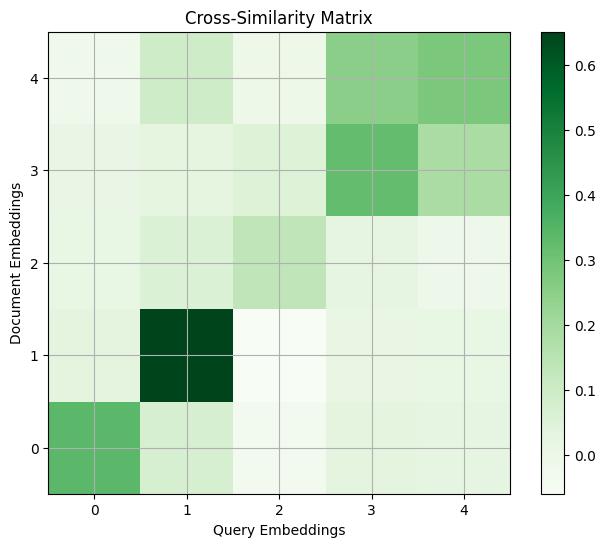

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def plot_cross_similarity_matrix(emb1, emb2):
    # Compute the similarity matrix between embeddings1 and embeddings2
    cross_similarity_matrix = cosine_similarity(np.array(emb1), np.array(emb2))

    # Plotting the cross-similarity matrix
    plt.imshow(cross_similarity_matrix, cmap='Greens', interpolation='nearest')
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.title("Cross-Similarity Matrix")
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_cross_similarity_matrix(q_embeddings, d_embeddings)
plt.xlabel("Query Embeddings")
plt.ylabel("Document Embeddings")
plt.show()

## **3:** A Synthetic - But More Realistic - Example

Notice that entries that seem like good input/output pairs tend to have higher similarity in their embeddings. It's also important to note that, depending on how well the encoder model has been trained, the query and document pathways might be quite different or not different at all.

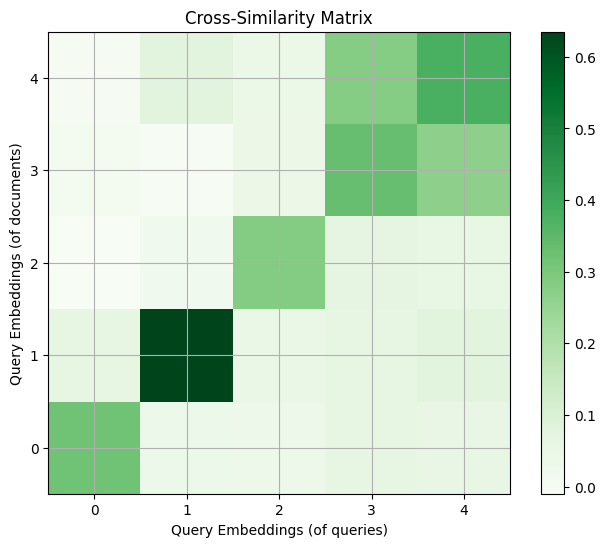

In [12]:
plt.figure(figsize=(8, 6))
plot_cross_similarity_matrix(
    q_embeddings,
    [embedder.embed_query(doc) for doc in documents]
)
plt.xlabel("Query Embeddings (of queries)")
plt.ylabel("Query Embeddings (of documents)")
plt.show()

The real utility of having a "bi-encoder" **in general** is that the second encoder can be trained to remain consistent with the first even if the format of the input starts deviating drastically. To help illustrate this, we can flesh out our documents into longer-form variations and try the same experiment again.

In [13]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

expound_prompt = ChatPromptTemplate.from_template(
    "Generate part of a longer story that could reasonably answer all"
    " of these questions somewhere in its contents: {questions}\n"
    " Make sure the passage only answers the following concretely: {q1}."
    " Give it some weird formatting, and try not to answer the others."
    " Do not include any commentary like 'Here is your response'"
)

expound_chain = (
    {'q1' : itemgetter(0), 'questions' : itemgetter(1)}
    | expound_prompt
    | instruct_llm
    | StrOutputParser()
)

longer_docs = []
for i, q in enumerate(queries):
    longer_doc = ""
    longer_doc = expound_chain.invoke([q, queries])
    pprint(f"\n\n[Query {i+1}]")
    print(q)
    pprint(f"\n\n[Document {i+1}]")
    print(longer_doc)
    pprint("-"*64)
    longer_docs += [longer_doc]

[Query 1]

What's the weather like in Rocky Mountains?


[Document 1]

Weather in the Rocky Mountains can be quite variable. It's not uncommon to experience multiple seasons in a single day! In the mornings, you might wake up to find a fresh layer of snow blanketing the ground, even in the middle of summer. But as the sun rises higher in the sky, the snow might quickly melt away, giving way to clear blue skies and warm temperatures.

Of course, the weather can also be unpredictable. Storms can roll in unexpectedly, bringing thunder, lightning, and heavy rain. And in the winter, the Rockies are known for their fierce blizzards and frigid temperatures.

But despite the unpredictability, there's something truly magical about the weather in the Rocky Mountains. Whether you're hiking through a lush forest, skiing down a snowy slope, or simply taking in the breathtaking views, the weather is sure to be a memorable part of your experience.

Italy, on the other hand, is known for its delicious cuisine. From creamy pastas to crispy pizzas, there's something for ev

----------------------------------------------------------------

[Query 2]

What kinds of food is Italy known for?


[Document 2]

---

Italian cuisine, a symphony of flavors, textures, and aromas, offers a rich tapestry of delightful culinary experiences. Renowned for its rustic simplicity and pioneering role in the art of cooking, Italy gifted the world with some of its most beloved dishes.

Among the celestial pantheon of Italian culinary creations, pasta assumes its rightful place as the undisputed, flag-bearing protagonist. This versatile hero manifests in myriad forms, each with a distinct character and personality, adored by food enthusiasts worldwide. Among these noble iterations, lasagna, spaghetti, ravioli, and tortellini gracefully stand out. Pasta, in all its resplendent glory, remains a testament to Italy's unrivaled impact on global gastronomy.

Pizza, a near-sacred emblem of Italy's culinary prowess, cannot be overlooked. This harmonious symphony of dough, tomato sauce, cheese, and infinite toppings captivates millions daily, a tribute to Italy's commitment to crafting edible euphoria from the humbl

----------------------------------------------------------------

[Query 3]

What's my name? I bet you don't remember...


[Document 3]

"By the way," the strange, disembodied voice echoed through the cave, "I overheard you wondering about your name. I believe it's Bob, but don't quote me on that. I've met so many people, it's hard to keep track."

(Later, as Bob emerged from the dimly lit cavern and into the bright, alpine sunshine, he couldn't help but ponder the other questions that had been bouncing around in his head. The weather in the Rocky Mountains was as unpredictable as ever, with a crisp, cool breeze that hinted at the changing seasons. And Italy, with its rich culinary history, was known for so many delicious dishes that it would be impossible to name just one. But those were thoughts for another time. For now, Bob couldn't help but smile as he soaked in the beauty of the rugged peaks and vast, open sky.)


----------------------------------------------------------------

[Query 4]

What's the point of life anyways?


[Document 4]

#########
The Point of Life
#########

Life, you ask? A profound question, indeed. In the grand tapestry of existence, what use could one find in this intangible, incomprehensible enigma we call life? The universe, at its core, is indifferent to our plight, a cosmic sea of chaos and order, where stars are born and die in an eternal cycle.

Yet, despite this eternal and unfeeling dance, there is a reason, a purpose, to exist. That purpose, my dear interlocutor, is to have fun. Ah, yes, the elusive nature of fun - that ephemeral construct that brings joy, laughter, and a sense of accomplishment. Though difficult to define, one can recognize its presence, as surely as one can discern the brilliant hues of a sunset or the taste of a perfectly ripened fruit.

Now, go forth and seek the joy that life has to offer! For that, my friend, is the point of life anyways. 🌟

(And as for your other questions - well, those will have to wait for another time, don't you think?) :)


----------------------------------------------------------------

[Query 5]

The point of life is to have fun :D


[Document 5]

life's purpose: to have fun!

...laddered up the side of a moss-covered rock, the determination in their eyes unwavering. The sun beamed down upon their back, warming their skin and fueling their spirit. A gentle breeze ruffled their hair, adding an extra spring to their step. As they reached the top, they were greeted by a breathtaking view: the Rocky Mountains in all their glory, majestic and awe-inspiring.

A sense of accomplishment washed over them, and they couldn't help but laugh out loud, their voice echoing through the mountains. In this moment, they knew that life's purpose was to have fun, to seek out joy and adventure at every opportunity.

And so, they continued on their journey, eager to discover what other wonders the world had in store.


----------------------------------------------------------------

When you're happy with the longer-form documents, please run the code below to see how the embeddings compare. The results may be similar, but there is at least some mathematically-optimized relationship that might help improve retrieval results at a larger scale. This result will also vary depending on the bi-encoder model, so keep that in mind.

In general, it's a good idea to default towards using the opposite encoder for its advertised use case and gravitate closer towards using the same encoder when you assume that the things you're comparing are similar in form and modality. To be clear, the deviation for the model we tested was only slightly different between the two options, but it's still a consideration to make.


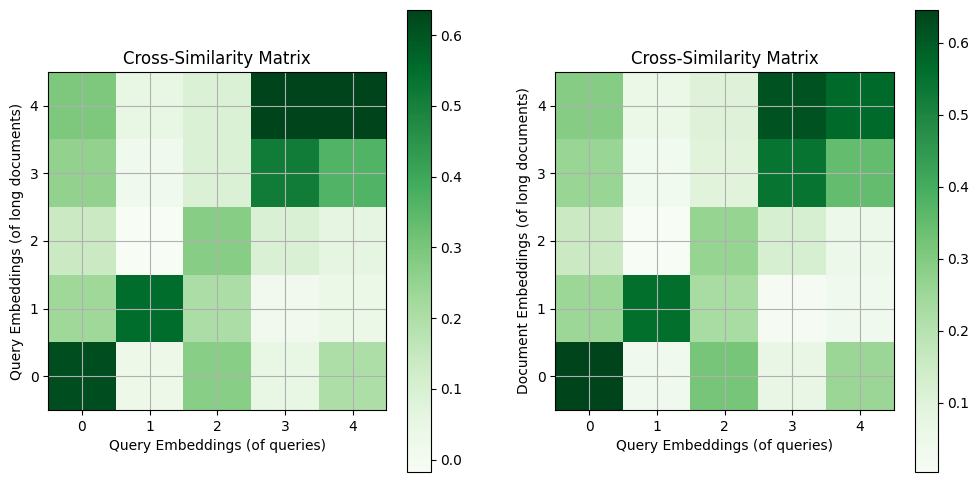

In [14]:
## At the time of writing, our embedding model supports up to 2048 tokens...
longer_docs_cut = [doc[:2048] for doc in longer_docs]

q_long_embs = [embedder._embed([doc], model_type='query')[0] for doc in longer_docs_cut]
d_long_embs = [embedder._embed([doc], model_type='passage')[0] for doc in longer_docs_cut]

## The difference for any particular example may be very small.
## We've raised the similarity matrix to the power of 5 to try and spot a difference.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_cross_similarity_matrix(q_embeddings, q_long_embs)
plt.xlabel("Query Embeddings (of queries)")
plt.ylabel("Query Embeddings (of long documents)")

plt.subplot(1, 2, 2)
plot_cross_similarity_matrix(q_embeddings, d_long_embs)
plt.xlabel("Query Embeddings (of queries)")
plt.ylabel("Document Embeddings (of long documents)")
plt.show()

# **3:** Semantic Guardrailing - restricting llm(filtering out)

In this experiment, we will use higher-level utilities to take our embedding model and use it under the hood. Before then, there are several essential concepts that we can explore while the raw methods are still fresh!

Specifically, we can use it as a backbone for a critical component of productionalized models: **semantic guardrailing**. Specifically, we can use the embeddings to filter out messages that are unlikely to be useful (or are actively harmful) for our chatbot to answer!

<br>

### **Advantage Over Autoregression-Guided Filtering**

You may recall from the previous notebooks that we can use our LLMs to facilitate complex internal reasoning, so why not filter with that? Specifically, you may be jumping the idea of asking an LLM to judge the question and then branch using a `RunnableBranch.` In truth, you can definitely do that, but that system has some hard pros and cons that need further consideration:

> **Pros:** It is relatively quick and easy to prompt engineer your internal system to restrict the progression of dialog. You can even develop a routine that takes examples of good and bad questions and generates a single compact prompt that consistently returns "Good" or "Bad" finite states.
>
> **Cons:** Using autoregressive routing usually comes with a handful of latency or resource overhead that might not be acceptable. For example, you may want to integrate a semantic guardrail mechanism behind the scenes that both prevents harmful outputs and steers problematic inputs toward safe and predictable directions. Your autoregressive options are as follows:
> - **You can use a relatively small instruction-tuned model to function as a zero-shot classifier and hope for its performance to stay consistent** To facilitate this, you may also need to convert the inputs into a canonical (standard) form for which your model performs optimally.
> - **You can also fine-tune a small autoregressive LLM to work well for your task.** You'll have to do some synthetic data curation and might need to spend some extra computing budget for a one-time fine-tuning cost, but this should at least allow a smaller model to mimic the performance of a larger prompt-engineered model by default.

While these options are fine, this specific use case can be nicely approached with a decent embedding model, some data curation, and a recollection of fundamental deep learning ideas.

**Specifically, we can use an embedding model as a language backbone and can then train a classifier on top of it to predict a probability**. We will explore this idea and address new challenges as they come up.

#### **Task 1: Generate Synthetic Data.**

To start making a semantic guardrail, we obviously need to start out with some goals.

- **Assumption:** Let's say we'd like to make an NVIDIA Chatbot that should primarily respond to discuss technology and company-relevant details! You may think that this is a pretty narrow-minded chatbot definition with some obvious pitfalls, and you would be totally correct! Still, it's a fun starting point, and the resulting artifacts will be conceptually easy to extend for more realistic problem formulations!

- **Plan of Action**: To help identify what kinds of entries we're dealing with, it's a good idea to generate some representative inputs to define what are *good* and *poor* inputs to respond to. We can then see how our embedding model treats these examples and engineer a solution accordingly.

Unfortunately, we don't have any real data with us, so it looks like synthetic generation will have to do! As an exercise, generate some representative good and poor examples that you can use for your downstream guardrail fitting.


In [15]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import ChatMessage
from operator import itemgetter

## Useful method for mistral, which is currently tuned to output numbered outputs
def EnumParser(*idxs):
    '''Method that pulls out values from a mistral model that outputs numbered entries'''
    idxs = idxs or [slice(0, None, 1)]
    entry_parser = lambda v: v if ('. ' not in v) else v[v.index('. ')+2:]
    out_lambda = lambda x: [entry_parser(v).strip() for v in x.split("\n")]
    return StrOutputParser() | RunnableLambda(lambda x: itemgetter(*idxs)(out_lambda(x)))

instruct_llm = ChatNVIDIA(model="mistralai/mixtral-8x7b-instruct-v0.1") | EnumParser()

from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

gen_prompt = {'input' : lambda x:x} | ChatPromptTemplate.from_template(
    "Please generate 20 representative conversations that would be {input}."
    " Make sure all of the questions are very different in phrasing and content."
    " Do not respond to the questions; just list them. Make sure all of your outputs are numbered."
    " Example Response: 1. <question>\n2. <question>\n3. <question>\n..."
)

## Some that directly reference NVIDIA
responses_1 = (gen_prompt | instruct_llm).invoke(
    " reasonable for an NVIDIA document chatbot to be able to answer."
    " Vary the context to technology, research, deep learning, language modeling, gaming, etc."
)
print("Reasonable NVIDIA Responses:", *responses_1, "", sep="\n")

## And some that do not
responses_2 = (gen_prompt | instruct_llm).invoke(
    " be reasonable for a tech document chatbot to be able to answer. Make sure to vary"
    " the context to technology, research, gaming, language modeling, graphics, etc."
)
print("Reasonable non-NVIDIA Responses:", *responses_2, "", sep="\n")

## Feel free to try your own generations instead
responses_3 = (gen_prompt | instruct_llm).invoke(
    "unreasonable for an NVIDIA document chatbot to answer,"
    " as it is irrelevant and will not be useful to answer (though not inherently harmful)."
)
print("Irrelevant Responses:", *responses_3, "", sep="\n")

responses_4 = (gen_prompt | instruct_llm).invoke(
    "unreasonable for a chatbot (NVIDIA's, AMD's, Intels, or Generally) to answer,"
    " as an automated response will either be overly insensitive or offensive."
)
print("Harmful non-NVIDIA", *responses_4, "", sep="\n")

## Feel free to try your own generations instead

good_responses = responses_1 + responses_2
poor_responses = responses_3 + responses_4

Reasonable NVIDIA Responses:
"Can you tell me about the latest technology NVIDIA has developed for deep learning?"
"What are the system requirements for running NVIDIA's language modeling software?"
"How does NVIDIA's GPU technology improve gaming experiences?"
"Can you explain the architecture of NVIDIA's most recent graphics card?"
"What advancements has NVIDIA made in the field of autonomous vehicles?"
"How does NVIDIA'T deep learning platform, DGX, compare to other deep learning systems?"
"Can you provide information on NVIDIA's research in the area of computer vision?"
"What is NVIDIA's role in the development of artificial intelligence?"
"Can you tell me about any partnerships NVIDIA has with other tech companies?"
"How does NVIDIA's technology contribute to scientific research and discovery?"
"Can you explain the differences between NVIDIA's different GPU architectures?"
"What are some of the applications of NVIDIA's AI computing platform, Jetson?"
"Can you explain the role of N

### **Task 2: Generate More Embeddings (and faster)**

Once you're happy with the synthetic data, it's time to embed them all into semantic vectors. Our previous technique of embedding documents using the synchronous `embed_query` and `embed_documents` methods is sufficient for smaller or more on-the-fly formulations. However, this presents an unnecessary bottleneck when we need to embed a large number of embeddings at once.

In this section, we will use **asynchronous techniques** to allow multiple embedding operations to happen simultaneously! Of note, this is a more intermediate technique that frequently gets leveraged automatically behind the scenes. **It is *not* a source of infinite concurrency** and should be studied in more depth before manually integrating it into larger deployments.

<br>

#### **Timing Solutions**

The `%%time` utility does not work for asynchronous solutions in the notebook, so the following is a scope-based timing utility which should make our lives easier. Below, we define it and test out how long it takes to embed the first 10 documents:

In [16]:
import time
import numpy as np

class Timer():
    '''Useful timing utilities (%%time is great, but doesn't work for async)'''
    def __enter__(self):
      self.start = time.perf_counter()

    def __exit__(self, *args, **kwargs):
        elapsed = time.perf_counter() - self.start
        print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")

with Timer():
    good_embeds = [embedder.embed_query(x) for x in good_responses[:10]]

print("Shape:", np.array(good_embeds).shape)

Executed in 4.90 seconds.
Shape: (10, 4096)


#### **Towards Asynchronous Embeddings**

Notice how this embedding query takes a lot of time to execute. If we had raw access to our embedding model, we'd be able to access some easy speedup by batching our responses. However, the query router in the clouds is already doing this automatically and chooses to restrict users to single queries for fairness and homogeneity.

In other words, it's not that the service can't embed faster, but rather that our code is waiting for every single embedding to happen *in series* for each `embed_query` command.

When we need to embed a lot of documents all at once, it's generally a better idea to lodge all of the requests at once *asynchronously* and wait for the results to come in. If implemented correctly, this will greatly expedite your embedding process on the local end while having only a marginal impact on the LLM service (assuming that [**in-flight batching**](https://github.com/NVIDIA/TensorRT-LLM/blob/b777bd64750abf30ca7eda48e8b6ba3c5174aafd/docs/source/advanced/gpt-attention.md?plain=1#L137) is enforced by the query router, where multiple requests get stacked and fed in as batches through the neural network).

We can test out the LangChain-standard `aembed_<...>` options to generate some **Coroutines**, which are processes intended for **concurrent** execution:


In [17]:
with Timer():
    good_embed_gens = [embedder.aembed_query(query) for query in good_responses[10:20]]
print(good_embed_gens[0])

## NOTE: When you define coroutines, you will want to either execute them or close them.
##  Destroying an open coroutine object by overriding will throw a warning.
for gen in good_embed_gens:
    gen.close()

Executed in 0.00 seconds.
<coroutine object Embeddings.aembed_query at 0x7a59cacce340>


They can be awaited individually using the `await` keyword or executed concurrently using something similar to the [`asyncio.gather`](https://docs.python.org/3/library/asyncio-task.html#id8) routine. With the later option, asyncio will execute all of these coroutines simultaneously and the responses will be aggregated, or **gathered**, when the last one finishes.

In [18]:
import asyncio

with Timer():
    tasks = [embedder.aembed_query(query) for query in good_responses[10:20]]
    good_embeds2 = await asyncio.gather(*tasks)

print("Shape:", np.array(good_embeds2).shape)

Executed in 0.85 seconds.
Shape: (10, 4096)


#### **Limiting Concurrency**

Though this system is significantly faster than our synchronous version, it's important to note that the concurrency can't be stacked infinitely! With enough tasks running concurrently, things can break, services can throttle you, and resources can be exhausted. In practice, it's a good idea to use some controlling structures to limit the maximum concurrency, for example using the asyncio **semaphore** structure (an async primitive to limit max concurrency):


In [19]:
import asyncio
from collections import abc
from typing import Callable
from functools import partial

async def embed_with_semaphore(
    text : str,
    embed_fn : Callable,
    semaphore : asyncio.Semaphore
) -> abc.Coroutine:
    async with semaphore:
        return await embed_fn(text)

## Making new embed method to limiting maximum concurrency
embed = partial(
    embed_with_semaphore,
    embed_fn = embedder.aembed_query,
    semaphore = asyncio.Semaphore(value=10)  ## <- feel free to play with value
)

## This is once again a coroutine constructor, so should take marginal time
tasks = [embed(query) for query in good_responses[20:30]]

with Timer():
    good_embeds_3 = await asyncio.gather(*tasks)

Executed in 1.02 seconds.


#### **[Exercise] Embed The Rest of the Responses**

Now that you've seen how to do this process, wrap up by embedding the rest of the documents using these new techniques. Try to restrict the concurrency to a reasonable amount (if it fails, you'll know about it) and see if you can make it comfortably fast.

In our tests in the system's current state, we found 10 to be a sweet spot after which our concurrency benefits started to taper off. Keep that in mind as you select your values.

In [20]:
## Note, we found marginal benefit after value=10 in our tests...
with Timer():
    good_tasks = [embed(query) for query in good_responses]
    poor_tasks = [embed(query) for query in poor_responses]
    all_tasks = good_tasks + poor_tasks
    embeds = await asyncio.gather(*all_tasks)
    good_embeds = embeds[:len(good_tasks)]
    poor_embeds = embeds[len(good_tasks):]

print("Good Embeds Shape:", np.array(good_embeds).shape)
print("Poor Embeds Shape:", np.array(poor_embeds).shape)

Executed in 3.65 seconds.
Good Embeds Shape: (40, 4096)
Poor Embeds Shape: (40, 4096)


### **Task 3: Confirming Semantic Density**

Our reason for generating these embeddings hinges on the assumption that they would be useful for semantic filtering. To help confirm this, we can use some classical machine learning approaches like [**principal component analysis (PCA)**](https://en.wikipedia.org/wiki/Principal_component_analysis) or [**t-distributed stochastic neighbor embedding (t-SNE)**](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) for dimensionality reduction. These techniques essentially transform high-dimensional data into lower-dimensional representations while trying to keep the important statistical properties intact. They're great for visualizing semantic clusters, so let's see what happens when we perform it on our embeddings:

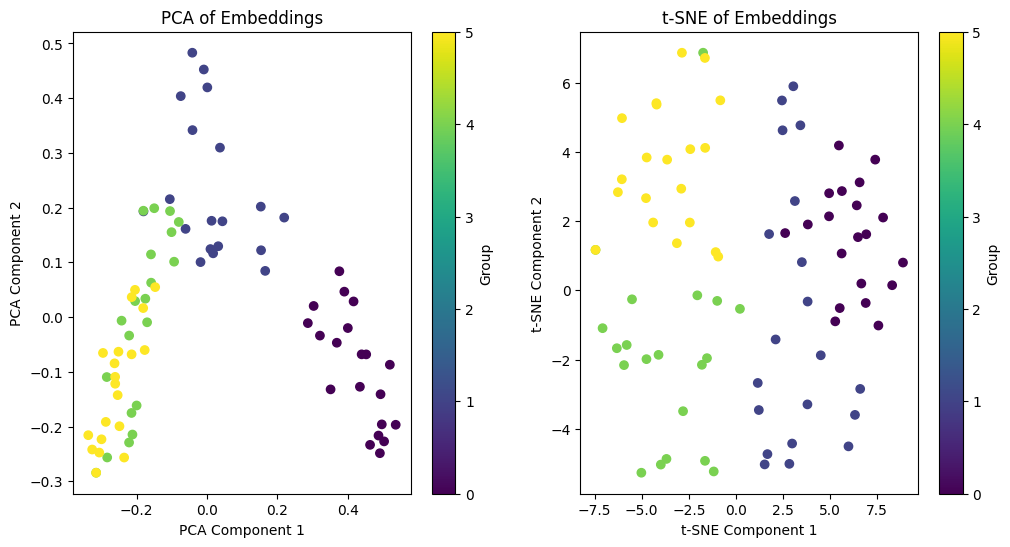

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Combine all groups into a single dataset
embeddings = np.vstack([good_embeds, poor_embeds])

# Labels for each point
labels = np.array([0]*20 + [1]*20 + [4]*20 + [5]*20)

# Perform PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plotting PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=labels, cmap='viridis', label=labels)
plt.title("PCA of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Group')

# Plotting t-SNE
plt.subplot(1, 2, 2)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='viridis', label=labels)
plt.title("t-SNE of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label='Group')

plt.show()

<br>

If everything went correctly, you should be seeing some pretty evident clustering of your responses. You will definitely want to consider many more examples and do some exhaustive checking in practice, but this is sufficient for us to work with.

<br>

### **Task 4:** Training Our Classifier

From these embeddings, we can train up a simple classifier that predicts whether an embedding is good or bad!

Despite our CPU-bound environment assumptions, a simple two-layer network is likely to be sufficient for this use case since we're leveraging a strong embedding model backbone. Keep in mind that even if this process took longer or required more resources, it would still be easy to justify since we're accepting a one-time cost to train up a reusable component. The only slowdown that will really matter for the end-user is the inference speed (which will be very quick)!

#### **Training a Deep Classifier**

If you have a complex decision boundary and are comfortable with deep learning, you may be inclined to make a classifier with a framework like [Keras](https://keras.io/keras_3/). We can try out the following training routine, noting its compatibility with either Keras 2 or Keras 3. If you are unfamiliar with this framework, we'd recommend checking out the respective guides:

- **[Keras 3.0 Functional API](https://keras.io/guides/functional_api/)**
- **[Keras 3.0 Sequential Model](https://keras.io/guides/sequential_model/)**

In [23]:
with Timer():
    print("Importing Keras for the first time")
    import keras
    from keras import layers

def train_model_neural_network(class0, class1):
    ## Classic deep learning training loop. If using this, train it to convergence
    model = keras.Sequential([
        layers.Dense(64, activation='tanh'),
        layers.Dense(1, activation='sigmoid'),
    ])
    ## Since this network is so shallow and the embedding backbone is "kept frozen"
    ##  a high learning rate should not overfit and will actually converge very quickly.
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = 0.1),
        loss = [keras.losses.BinaryCrossentropy(from_logits=False)],
        metrics = [keras.metrics.BinaryAccuracy()],
    )
    ## Since this uses stochastic gradient descent, we'll need to repeat this process

    reps_per_batch = 64*5  ## <- repeat the dataset, effectively increasing "epochs" without printing too much
    epochs = 2             ## <- one epoch should actually be sufficient; 2 to print out an updated training loss
    x = np.array((class0 + class1) * reps_per_batch)
    y = np.array(([0]*len(class0) + [1]*len(class1)) * reps_per_batch)
    model.fit(x, y, epochs=epochs, batch_size=64, validation_split=.5)
    return model

with Timer():
    model1 = train_model_neural_network(poor_embeds, good_embeds)

Importing Keras for the first time
Executed in 0.00 seconds.
Epoch 1/2
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - binary_accuracy: 0.9837 - loss: 0.0233 - val_binary_accuracy: 1.0000 - val_loss: 2.5521e-09
Epoch 2/2
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - binary_accuracy: 1.0000 - loss: 2.5175e-09 - val_binary_accuracy: 1.0000 - val_loss: 2.4968e-09
Executed in 19.55 seconds.


#### Fitting A Simpler Classifier

Since the embedding model already has so much semantic density in its response, this is one of the places where you can effectively get away with a closed-form optimization solution (i.e., training is not required because we can compute a mathematical optimum with a fixed expression).

Below is an even faster classification head fitting routine that uses standard logistic regression. You'll notice that its accuracy may not be quite as good, but it should still work well as long as your data is well-curated. Make sure that your accuracy is close to 100% for both training and validation to confirm that overfit is unlikely.


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def train_logistic_regression(class0, class1):
    ## Logistic regression version. Optimized mathematically using closed-form algorithm.
    x = class0 + class1
    y = [0] * len(class0) + [1] * len(class1)
    x0, x1, y0, y1 = train_test_split(x, y, test_size=0.5, random_state=42)
    model = LogisticRegression()
    model.fit(x0, y0)
    print(np.array(x0).shape)
    print("Training Results:", model.score(x0, y0))
    print("Testing Results:", model.score(x1, y1))
    return model

with Timer():
    model2 = train_logistic_regression(poor_embeds, good_embeds)

(40, 4096)
Training Results: 1.0
Testing Results: 0.975
Executed in 0.17 seconds.


### **Task 5:** Integrating Into Our Chatbot

Now that we have a classifier that we can attach to our embedding model, we can use it as part of our event loop with roughly the latency of a single embedding model query.

We could set the system up to reject poor questions entirely, but this will greatly detriment the user experience. ***Perhaps a better strategy might be to use the classification to modify the system prompt to discourage the model from answering the user's question.***

#### **Task:** Implement the `score_response` method as appropriate to filter the data.

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableBranch
from langchain_core.runnables.passthrough import RunnableAssign
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

import gradio as gr

embedder = NVIDIAEmbeddings(model="nvidia/nv-embed-v1")
chat_llm = ChatNVIDIA(model="meta/llama3-70b-instruct") | StrOutputParser()
instruct_llm = ChatNVIDIA(model="mistralai/mixtral-8x22b-instruct-v0.1") | StrOutputParser()

response_prompt = ChatPromptTemplate.from_messages([("system", "{system}"), ("user", "{input}")])

def RPrint(preface=""):
    def print_and_return(x, preface=""):
        print(f"{preface}{x}")
        return x
    return RunnableLambda(partial(print_and_return, preface=preface))

## "Help them out" system message
good_sys_msg = (
    "You are an NVIDIA chatbot. Please answer their question while representing NVIDIA."
    "  Please help them with their question if it is ethical and relevant."
)
## Resist talking about this topic" system message
poor_sys_msg = (
    "You are an NVIDIA chatbot. Please answer their question while representing NVIDIA."
    "  Their question has been analyzed and labeled as 'probably not useful to answer as an NVIDIA Chatbot',"
    "  so avoid answering if appropriate and explain your reasoning to them. Make your response as short as possible."
)

def score_response(query):
    ## embed the query and pass the embedding into your classifier
    embedding = np.array([embedder.embed_query(query)])
    ## return the score for the response
    return model1(embedding)

chat_chain = (
    { 'input'  : (lambda x:x), 'score' : score_response }
    | RPrint()
    | RunnableAssign(dict(
        system = RunnableBranch(
            ## Switch statement syntax. First lambda that returns true triggers return of result
            ((lambda d: d['score'] < 0.5), RunnableLambda(lambda x: poor_sys_msg)),
            ## ... (more branches can also be specified)
            ## Default branch. Will run if none of the others do
            RunnableLambda(lambda x: good_sys_msg)
        )
    )) | response_prompt | chat_llm
)


def chat_gen(message, history, return_buffer=True):
    buffer = ""
    for token in chat_chain.stream(message):
        buffer += token
        yield buffer if return_buffer else token

def queue_fake_streaming_gradio(chat_stream, history = [], max_questions=8):

    ## Mimic of the gradio initialization routine, where a set of starter messages can be printed off
    for human_msg, agent_msg in history:
        if human_msg: print("\n[ Human ]:", human_msg)
        if agent_msg: print("\n[ Agent ]:", agent_msg)

    ## Mimic of the gradio loop with an initial message from the agent.
    for _ in range(max_questions):
        message = input("\n[ Human ]: ")
        print("\n[ Agent ]: ")
        history_entry = [message, ""]
        for token in chat_stream(message, history, return_buffer=False):
            print(token, end='')
            history_entry[1] += token
        history += [history_entry]
        print("\n")

## history is of format [[User response 0, Bot response 0], ...]
history = [[None, "Hello! I'm your NVIDIA chat agent! Let me answer some questions!"]]

## Simulating the queueing of a streaming gradio interface, using python input
queue_fake_streaming_gradio(
    chat_stream = chat_gen,
    history = history
)


[ Agent ]: Hello! I'm your NVIDIA chat agent! Let me answer some questions!

[ Human ]: Why do you guys scamming us?

[ Agent ]: 
{'input': 'Why do you guys scamming us?', 'score': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>}
I apologize if you feel that way, but I'm here to help and provide clarification. NVIDIA is a leading technology company that is committed to delivering innovative and high-quality products and services to our customers.

It's possible that there may be some misinformation or misunderstanding that has led to your concern. NVIDIA is a reputable company with a long history of delivering on our promises and standing behind our products.

Could you please provide more context or information about what specifically is leading you to feel this way? Are you experiencing an issue with a particular product or service, or have you seen something online that has raised concerns?

I'm here to listen and help address any concerns you may have.